In [1]:
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

from torchvision import  transforms
from torchvision import  models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder


In [2]:
main_dir = os.getcwd()
train_dir = os.path.join(main_dir, "train")
test_dir = os.path.join(main_dir, "test")
valid_dir = os.path.join(main_dir, "valid")

In [3]:
def load_train_dataset(data_path):
    transformation = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train_dataset = ImageFolder(root=data_path, transform=transformation)
    train_loader = DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle=True)
    
    return train_dataset, train_loader

def load_test_dataset(data_path):
    transformation = transforms.Compose([
        transforms.Resize((244, 244)),  
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    test_dataset = ImageFolder(root=data_path, transform=transformation)
    test_loader = DataLoader(test_dataset, batch_size=64, num_workers=0, shuffle=True)
    
    return test_dataset, test_loader
    
def valid_test_dataset(data_path):
    transformation = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    valid_dataset = ImageFolder(root=data_path, transform=transformation)
    valid_loader = DataLoader(valid_dataset, batch_size=64, num_workers=0, shuffle=True)

    return valid_dataset, valid_loader

In [4]:
def visualize_batch(batch, brightness_factor=1.5, contrast_factor=1.5):
    adjusted_batch = batch * brightness_factor
    mean = torch.mean(adjusted_batch, dim=[2, 3], keepdim=True)
    adjusted_batch = (adjusted_batch - mean) * contrast_factor + mean
    
    adjusted_batch = torch.clamp(adjusted_batch, 0, 1)
    
    grid_img = make_grid(adjusted_batch, nrow=5)
    
    plt.figure(figsize=(12, 15))
    plt.imshow(np.transpose(grid_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

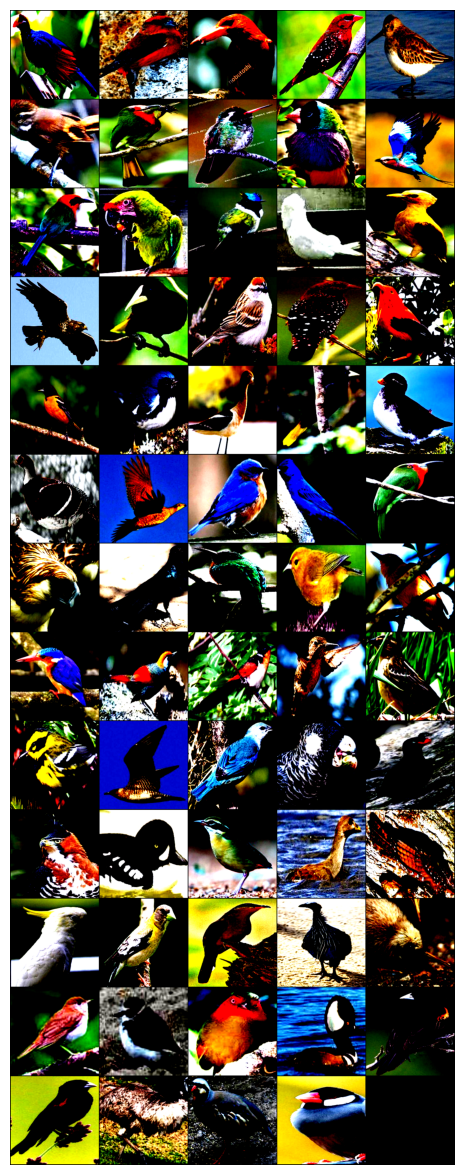

In [5]:
trainset, train_loader = load_train_dataset(train_dir)
images, _  = next(iter(train_loader))

visualize_batch(images)

In [6]:
model = models.resnet18(pretrained=True)
CLASSES = trainset.classes
num_classes = len(CLASSES)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
       
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(trainset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [ ]:
testset, test_loader = load_test_dataset(test_dir)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = models(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct +=  (predicted == labels).sum().item()
        
print(f"Accuracy on test set: {(100 * correct / total):.2f}%")